# Vision
This is a dev file for the vision module

### 1- Importing necessary librairies

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Vision.CamCalib as cb
import Vision.EnvTracker as tracker
import importlib
importlib.reload(cb)
importlib.reload(tracker)
import matplotlib.colors as colors
import math

### 2- Camera Calibration (Removing distortions)
Based on this OpenCV [tutorial](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html) 

i. Using the CamCalib object, take some pictures with the chessboard pattern if not already done

In [9]:
cam_stream = cv2.VideoCapture(0)
cam_stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam_stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

calib = cb.CamCalib(cam_stream, (9,6))
calib.take_pictures()

cam_stream.release()

In [211]:
tag = cv2.aruco.generateImageMarker(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), 6, 100)
cv2.imwrite('ArucoTags/m6.png', tag)

True

ii. Use the calibrate function to extract camera parameters and save them in a numpy .npz file to load them later

Calibration success!
Camera matrix:
[  1538.444982409265	0.0	965.8124126873976
0.0	1552.5200098627963	517.8256512597918
0.0	0.0	1.0  ]


(-0.5, 999.5, 699.5, -0.5)

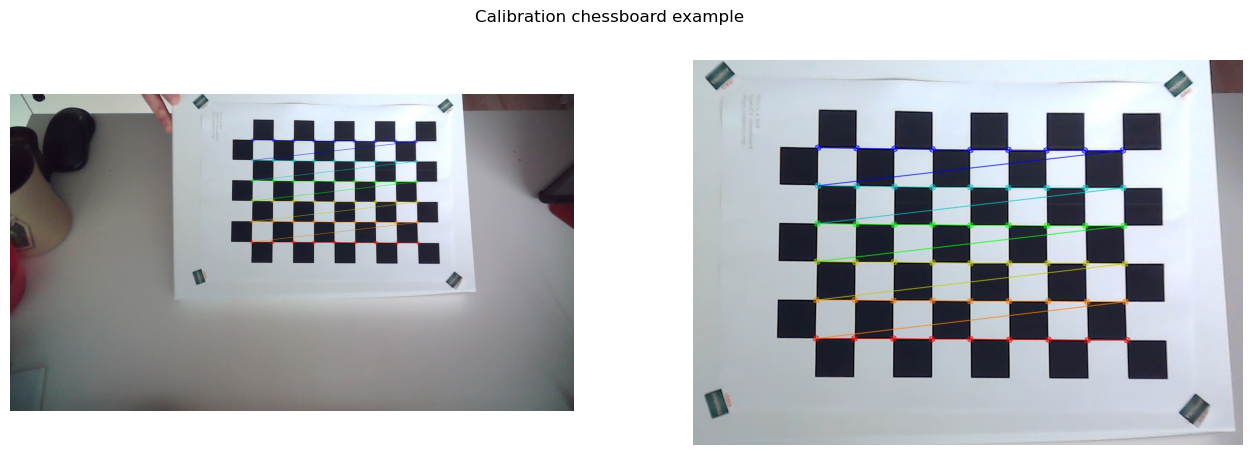

In [32]:
calib = cb.CamCalib(None, (9,6))
calib.calibrate(25, save_params=False)

# Show example
fig, ax = plt.subplots(1,2)
fig.suptitle('Calibration chessboard example')
fig.set_size_inches(16,5)
im1 = cv2.imread('Vision/images/cal/marked_4.jpg')
ax[0].imshow(im1[:,:,::-1])
ax[0].axis('off')
ax[1].imshow(im1[:700,600:1600,::-1])
ax[1].axis('off')


As one can see, OpenCV detects intersection between black squares. Knowing the size of each square (here 25 mm), it can deduce a mapping from object points to image points. Thus, having multiple viewpoints create a set of equations taht are used to find the parameters that minimizes the re-projection error. This calibration is crucial to straighten the lines of the image and to retrieve camera matrix and distorsions parameters. Knowing all of that allows to estimate accurately distances of objects in image!

iii. Apply the correction to the image

Using a remap function to undistord the image

(19, 12, 1256, 704)


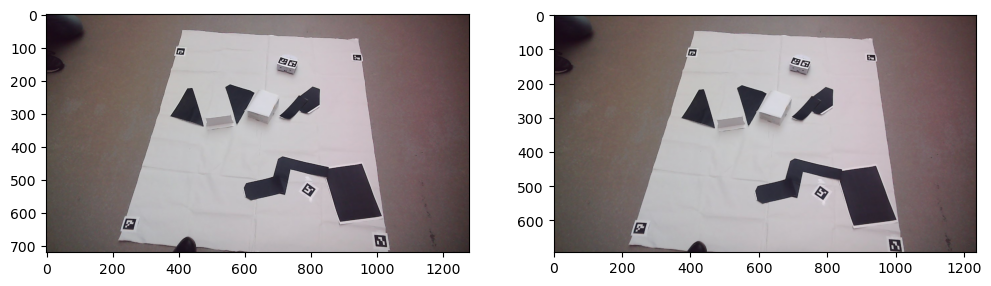

In [33]:
MAP_FILE = "Vision/images/THYMIO_ENV_PERM.jpg"
# Load parameters
cam_mat, dist_coefs, rvecs, tvecs = calib.load_camera_params()

test_img = cv2.imread(MAP_FILE)
# Get optimal camera matrix to keep img dimension the same
h, w = test_img.shape[:2]
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_coefs, (w,h), 1, (w,h), 0)
print(roi)
x,y,w,h = roi

# Using remapping
mapx, mapy = cv2.initUndistortRectifyMap(cam_mat, dist_coefs, None, new_cam_mat, (w,h), 5)
test_img_corr = cv2.remap(test_img, mapx, mapy, cv2.INTER_LINEAR)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,4)
axs[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

#test_img_corr = cv2.undistort(test_img, cam_mat, dist_coefs, None, new_cam_mat)
axs[1].imshow(test_img_corr[y:y+h,x:x+w,::-1])


### 3- Marker pose detection
i. Prepare environment (load previous calib data)

In [34]:
calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = calib.load_camera_params()
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_coefs, (1920,1080), 1, (1920,1080), 0)

ii. Identify aruco markers in camera feed

This is done using the [Aruco Marker Detector](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html) Module of OpenCV

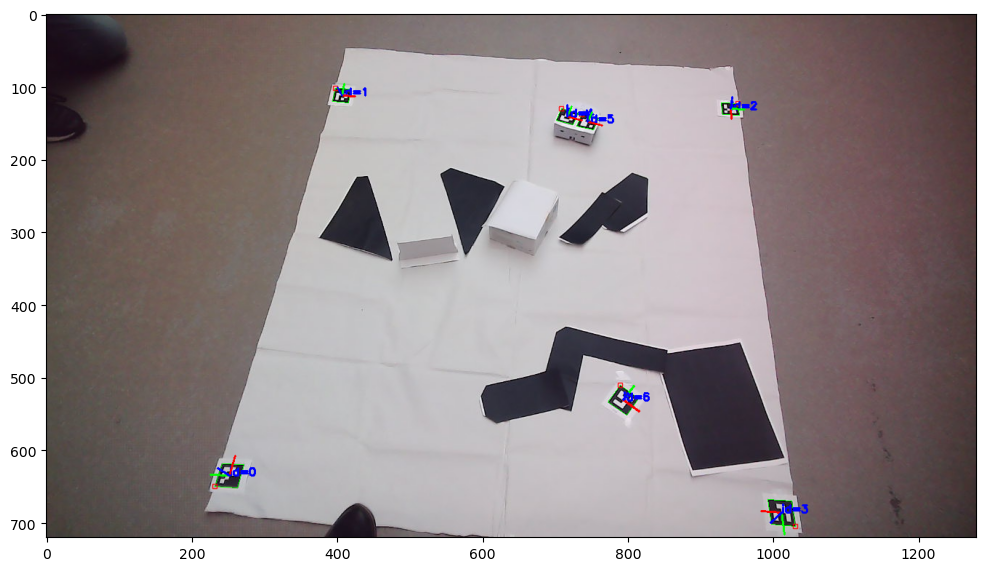

In [36]:
ORIGIN_ID = 1
MARKER_SIZE = 1.15
detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
img_dectect = cv2.copyTo(test_img, None)
corners, ids, rejected = detector.detectMarkers(img_dectect)
img_detection = cv2.aruco.drawDetectedMarkers(img_dectect, corners, ids)
# Create corner points
obj_points = cv2.Mat(np.array([[-MARKER_SIZE/2, MARKER_SIZE/2, 0], 
                        [MARKER_SIZE/2, MARKER_SIZE/2, 0], 
                        [MARKER_SIZE/2, -MARKER_SIZE/2, 0], 
                        [-MARKER_SIZE/2, -MARKER_SIZE/2, 0]]))


for c in corners:
    ret, rvec, tvec = cv2.solvePnP(obj_points, c, cam_mat, dist_coefs)
    img_detection = cv2.drawFrameAxes(img_detection, cam_mat, dist_coefs, rvec, tvec, 1, 2)


fig = plt.figure(figsize=(12,8))
plt.imshow(img_detection[:,:,::-1])

### 4- Extract map from environment

This section describes in details the basic idea of deteting and extracting the map and the obstacles position. A more condensed and direct demo using a dedicated python object is presented in the section [Pose Estimation of the Thymio](#pose-estimation-of-the-thymio)

Couple of steps to extract the obstacles and create the map.

**Assumptions**

- Map is a white background
- Map is a square of size 120x120 cm
- Obstacles are **black** and 2D shaped for simplicity
- Obstacles need to be closed shapes
- Map corners are delimited by markers of IDs 0,1,2,3 in this order
- Origin is at the bottom left corner

The main steps are the following
1. Undistord the camera image
2. Detect the markers and create map limits (respecting each corner)
3. Project the map to use a linear relationship between pixel space and metric space (pixel <--> cm)
4. Filter with Gaussian Blur and use Sobel in both direction (x,y) to detect edges
5. Apply a binary threshold and fill detected shapes
6. Extract occupied cell using pixels average within a grid cell

[267 110 779 547]


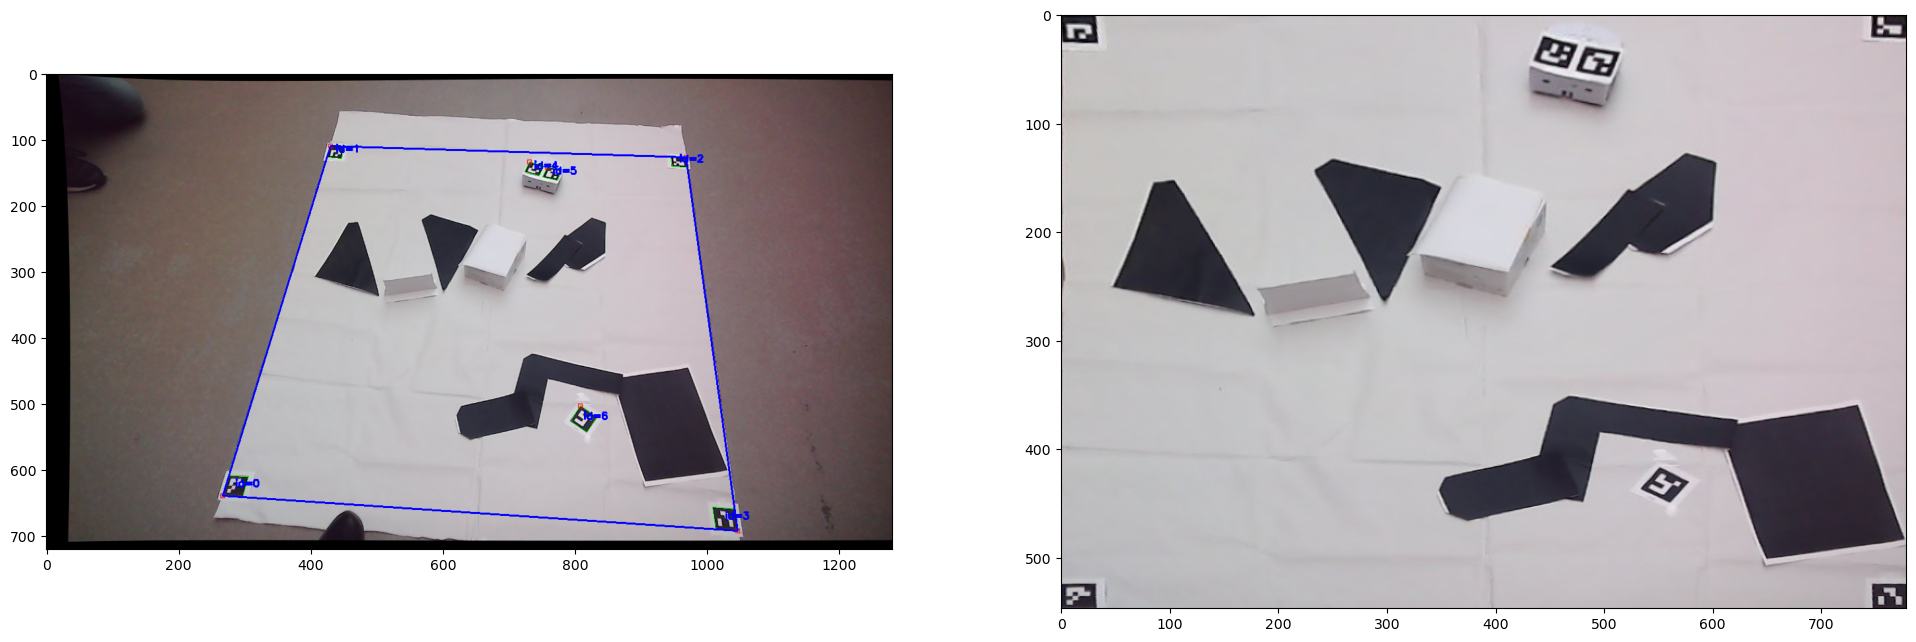

In [37]:
# Draw map limits
img_borders = cv2.imread(MAP_FILE)
#Undistort the image
w,h = img_borders.shape[0:2][::-1]
mapx, mapy = cv2.initUndistortRectifyMap(cam_mat, dist_coefs, None, new_cam_mat, (w,h), 5)
img_borders = cv2.remap(img_borders, mapx, mapy, cv2.INTER_LINEAR)
# Detect the markers
MARKER_SIZE = 5
detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
img_dectect = cv2.copyTo(img_borders, None)
corners, ids, rejected = detector.detectMarkers(img_dectect)
img_detection = cv2.aruco.drawDetectedMarkers(img_dectect, corners, ids)
map_img = cv2.copyTo(img_borders, None)

# Delimitate the map using outter corner of each marker
order_id = (0,1,2,3)
corner_num = (0,0,0,0)
roi_points = []
for i in range(len(order_id)):
    corner_index = np.argwhere(ids[:,0] == order_id[i])[0,0]
    next_corner = np.argwhere(ids[:,0] == order_id[(i+1)%4])[0,0]
    p1 = np.array([corners[corner_index][0][corner_num[i],0], corners[corner_index][0][corner_num[i],1]], dtype=int)
    p2 = np.array([corners[next_corner][0][corner_num[(i+1)%len(corner_num)],0], corners[next_corner][0][corner_num[(i+1)%len(corner_num)],1]], dtype=int)
    roi_points.append(p1)
    cv2.line(img_detection,p1.astype(int), p2.astype(int), [255,0,0], 2)

p_mid_down = (roi_points[3] + roi_points[0])/2
p_mid_up = (roi_points[2] + roi_points[1])/2
roi_map = np.array([roi_points[0][0], roi_points[1][1], roi_points[3][0]-roi_points[0][0], p_mid_down[1] - p_mid_up[1]], dtype=int)

# BEFORE
fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_detection[:,:,::-1])

# AFTER THE PROJECTION
x,y,w,h = roi_map
m_perspective = cv2.getPerspectiveTransform(np.float32(roi_points), np.float32([[0,h],[0,0],[w,0],[w,h]]))
map_img = cv2.warpPerspective(map_img, m_perspective, (w,h))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(map_img[:,:,::-1])



Edges detection (keeping ROI delimited by markers)

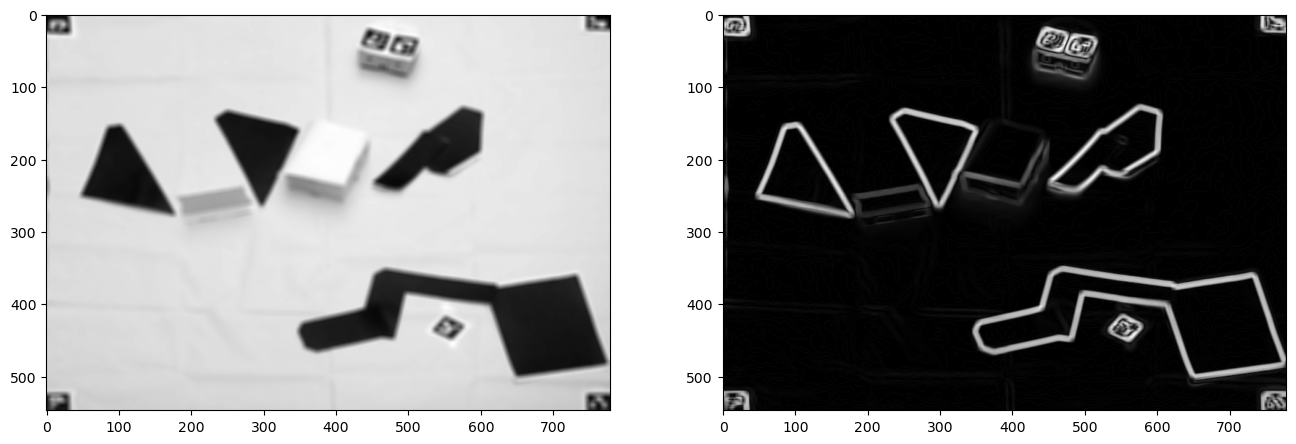

In [38]:
# Using the re-projected map from last step
img = cv2.cvtColor(map_img, cv2.COLOR_BGR2GRAY)
img_filtered = cv2.GaussianBlur(img, (9,9), 6)


fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_filtered, cmap='gray')

sobx = cv2.Sobel(img_filtered, cv2.CV_64F, 1, 0, 3)
soby = cv2.Sobel(img_filtered, cv2.CV_64F, 0, 1, 3)
sob = np.sqrt(sobx**2 + soby**2)
sob = (sob * 255 / sob.max()).astype(np.uint8)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sob, cmap='gray')




Binary threshold and shape filling

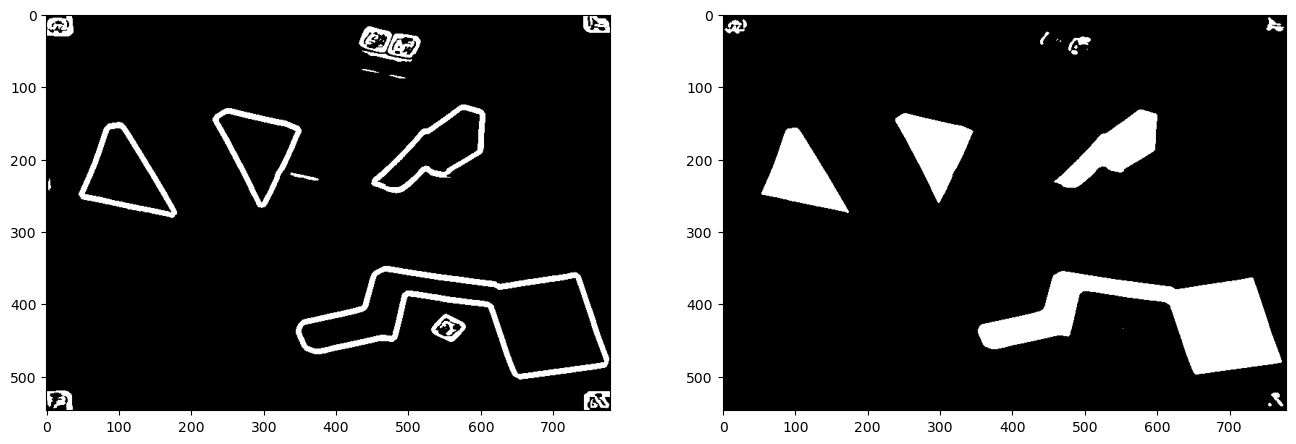

In [39]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)

# Apply threshold
cv2.threshold(sob, 100, 255, cv2.THRESH_BINARY, sob)
ax1.imshow(sob, cmap='gray')

contours, hierarchy = cv2.findContours(sob, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter out contours based on hierarchy
filtered_contours = []

for i, contour in enumerate(contours):
    # Check if the contour has a parent (it is a hole inside another shape)
    has_parent = hierarchy[0, i, 3] != -1

    # Check if the contour has a child (it contains another shape)
    has_child = hierarchy[0, i, 2] != -1

    if has_parent and not has_child:
        filtered_contours.append(contour)
# Create an empty image to draw the filtered contours
filtered_image = np.zeros_like(sob)

# Draw the filtered contours on the empty image
filtered_image = cv2.drawContours(filtered_image, filtered_contours, -1, 255, thickness=cv2.FILLED)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(filtered_image, cmap='gray')

*QUICK NOTE* : The noise is removed in the completed function *create_map* in the EnvTracker.py file. Markers and thymio are covered with pixels the same color as the average of the image (mostly white) before extracting the edges and doing the thresholding. Also, non-closed shapes are removed from the image (helps to filter unwanted detections)

Plotting function for the grid map

In [41]:
import matplotlib.ticker as ticker

def configure_ax(ax, max_x, max_y, res):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    MAJOR = 10
    MINOR = 5
    
    major_ticks_x = np.arange(0, max_x+1, MAJOR)
    minor_ticks_x = np.arange(0, max_x+1, MINOR)
    major_ticks_y = np.arange(0, max_y+1, MAJOR)
    minor_ticks_y = np.arange(0, max_y+1, MINOR)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_y])
    ax.set_xlim([-1,max_x])
    ax.set_ylabel('y (cm)')
    ax.set_xlabel('x (cm)')
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/res))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/res))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.grid(True)

    return ax

Having all of the edges, compute the grid and fill it accordingly.

For this step, knowing the true size (120,120) of the map in the real world and knowing a desired resolution (here we use 1 cell per cm), one can compute the number of pixels contained in one cell. Knowing this, computing an average of the pixels in that grid cell and apply a threshold to determine if it is occupied (obstacle) or not.

The grid map is defined as follow:  (120, 120)
Pixels per grid cell: 6.491666666666666 x 4.558333333333334


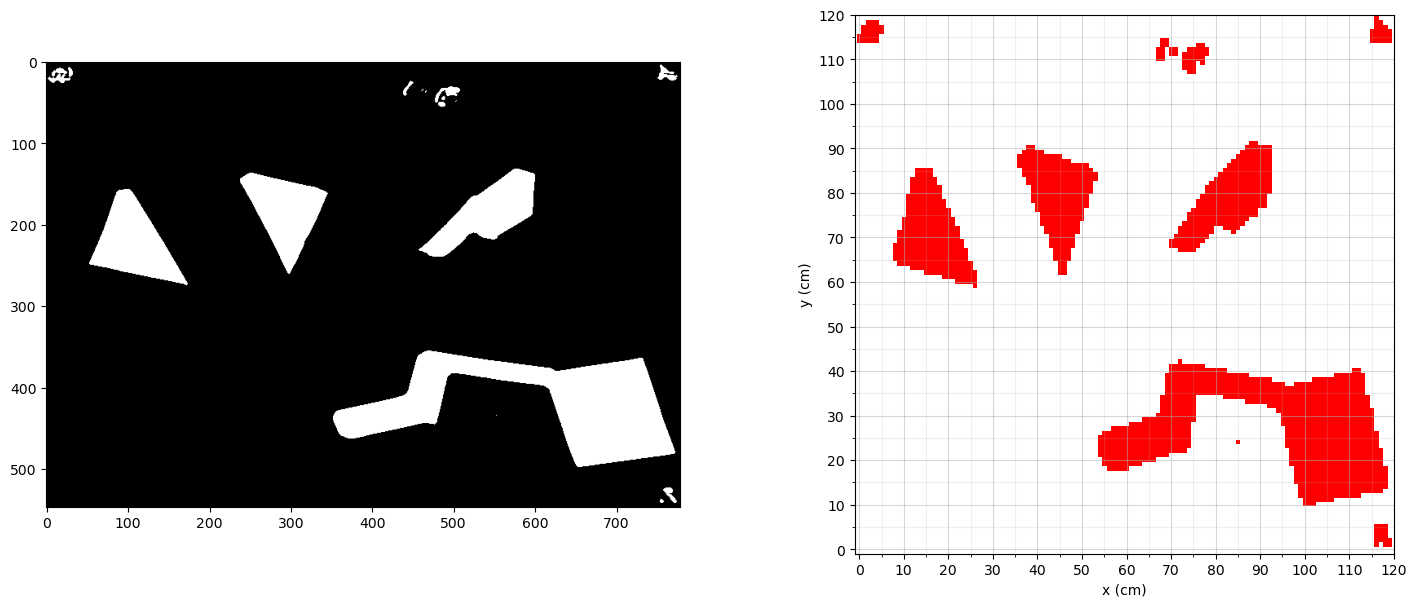

In [44]:
# Real map corners
MAP_W, MAP_H = 120,120  # In centimeters
CORNERS_REAL_POS = np.array([[0,0], [0,MAP_H], [MAP_W, MAP_H], [MAP_W,0]])
RES = 1 # Number of cells per centimeter
THRESHOLD = 80 # 0-255 for pixel intensity

#Initialize the grid
grid_map = np.zeros(((int)(RES*MAP_W), (int)(RES*MAP_H)))
print("The grid map is defined as follow: ", grid_map.shape)

# Find grid shape in pixel space
img_edges = cv2.copyTo(filtered_image, None)
h,w = img_edges.shape
grid_w, grid_h = w/(RES*MAP_W), h/(RES*MAP_H)
print(f'Pixels per grid cell: {grid_w} x {grid_h}')

# Applying threshold to get binary and measuring average and sum of cells in pixel space
cv2.threshold(img_edges, THRESHOLD, 255, cv2.THRESH_BINARY, img_edges)
for i in range(len(grid_map)):
    for j in range(len(grid_map[0])):
        c_x = math.floor(i*grid_w) + grid_w/2
        c_y = math.floor((len(grid_map[0])-1-j)*grid_h) + grid_h/2
        im_rect = cv2.getRectSubPix(img_edges, ((int) (round(grid_w, 0)),(int) (round(grid_h,0))), (c_x,c_y))
        grid_map[i,j] = 1 if cv2.sumElems(im_rect)[0] > cv2.mean(im_rect)[0] else 0

# Show the grid
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(1,2,2)
ax = configure_ax(ax, grid_map.shape[0], grid_map.shape[1], RES)
cmap = colors.ListedColormap(['white', 'red'])
ax.imshow(grid_map.transpose(), cmap=cmap, origin='lower')
ax = fig.add_subplot(1,2,1)
ax.imshow(img_edges, cmap='gray')


This was just a demo of the principle used to extract obstacles based on the assumptions made. The actual code implemented in *EnvTracker.py* is tuned to perform better the global map extraction based on our defined environment. The section below uses this new object(class) to generate the map.

## **Pose estimation of the Thymio**

1. Load saved image for demo purposes

Perform image correction based on extracted parameters. These parameters have been saved in a file to retrieve them easily!

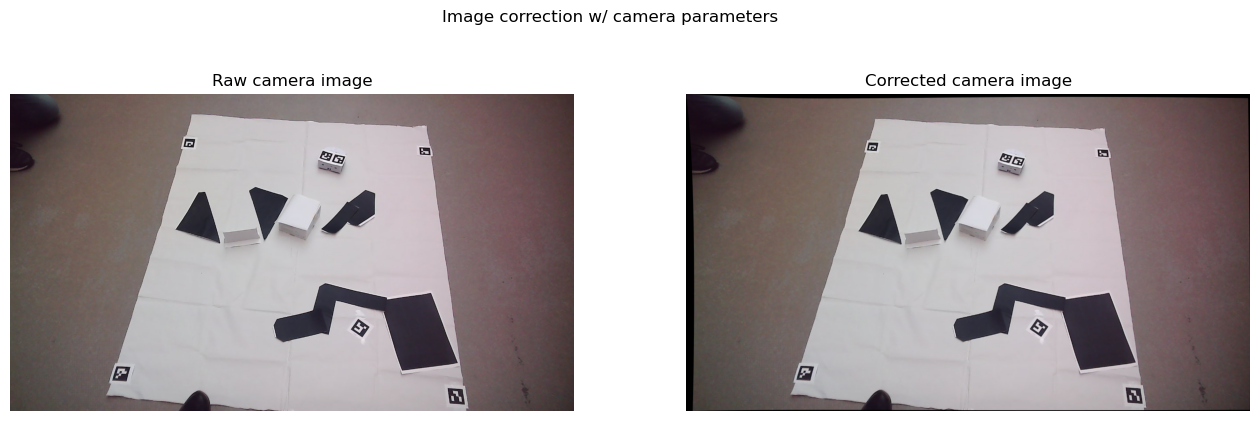

In [45]:
# Retrieve cam params
importlib.reload(cb)
cam_calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()

# Load and show demo image & corrected image
thymio = cv2.imread('Vision/images/THYMIO_ENV_PERM.jpg', cv2.IMREAD_COLOR)
fig, ax = plt.subplots(1,2)
fig.set_size_inches((16,5))
fig.suptitle('Image correction w/ camera parameters')
ax[0].axis('off')
ax[0].set_title('Raw camera image')
ax[0].imshow(thymio[:,:,::-1])
thymio, roi = cam_calib.undistord(thymio, cam_mat, dist_coefs)
ax[1].axis('off')
ax[1].set_title('Corrected camera image')
ax[1].imshow(thymio[:,:,::-1])


Pixels per grid cell: 6.55 x 4.625
Goal detected @:  [85.53435115 24.86486486]


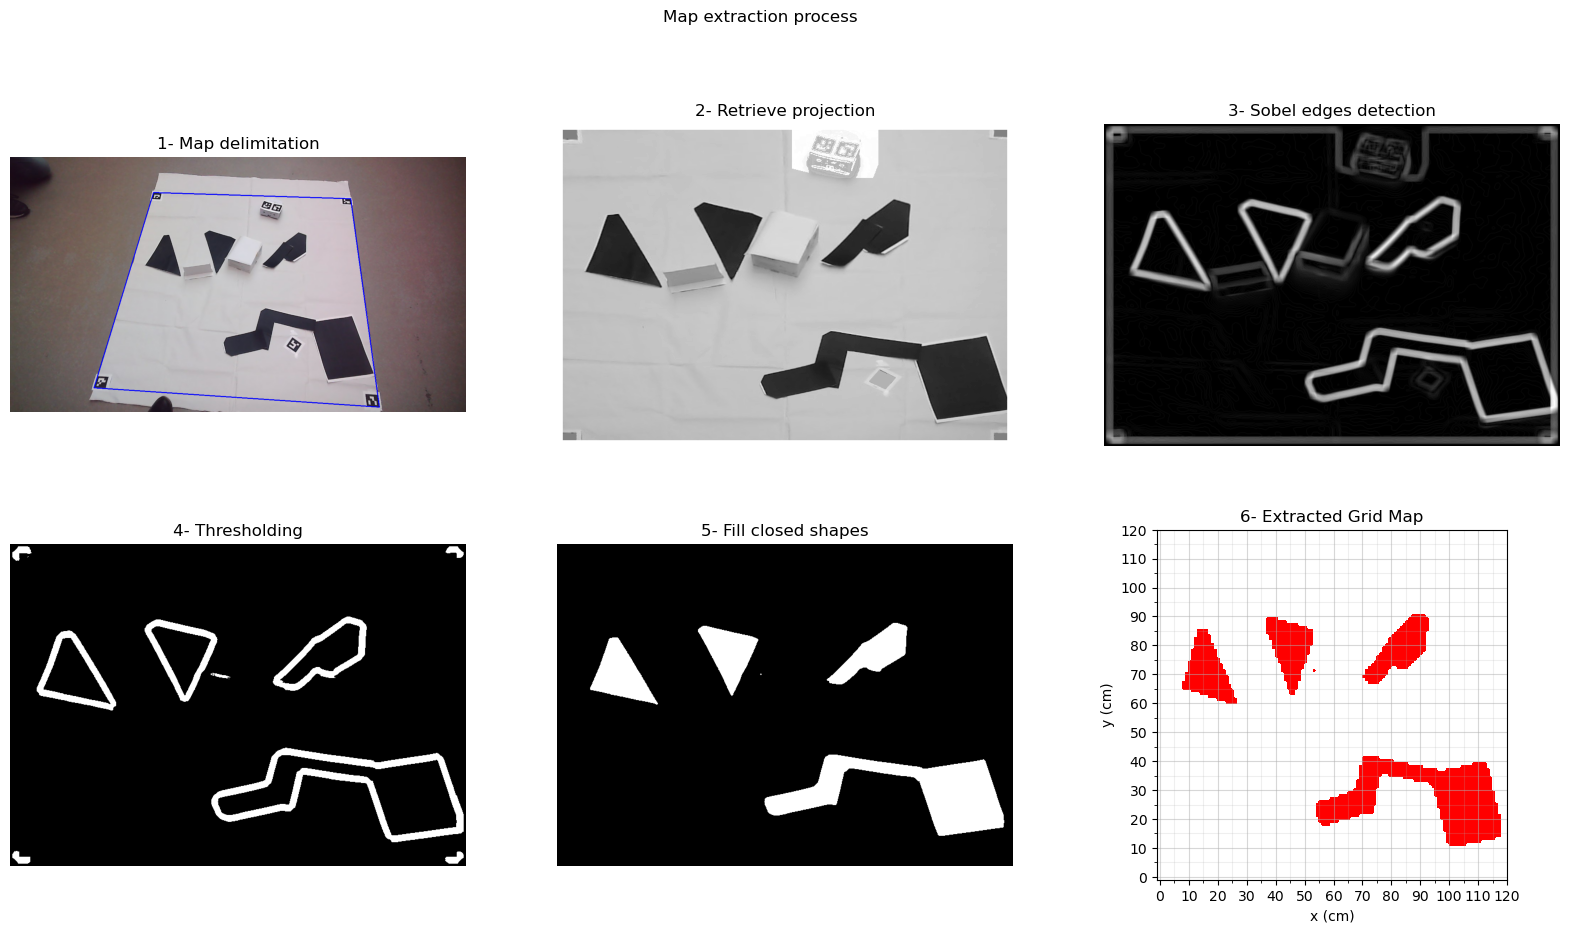

In [46]:
#%matplotlib inline
# For debugging/testing, use saved image
importlib.reload(tracker)
MAP_SIZE = (120,120)
env_tracker = tracker.EnvTracker(MAP_SIZE, cam_mat, dist_coefs)
# Keeping just the roi of the corrected image
x,y,w,h = roi
thymio = thymio[y:y+h,x:x+w,:]
ret, img_markers = env_tracker.detectMarkers(thymio)
map_detected, img_markers = env_tracker.detectMap(thymio)
goal_detected, img_markers = env_tracker.detectGoal(thymio)
grid_map, goal_pose, _ = env_tracker.createMap(thymio)

2. Detect thymio and extract pose & orientation from 2D projected map

Estimated thymio pose:  [ 73.1870229  107.02702703]
Estimated angle: 67.43


(-0.5, 785.5, 554.5, -0.5)

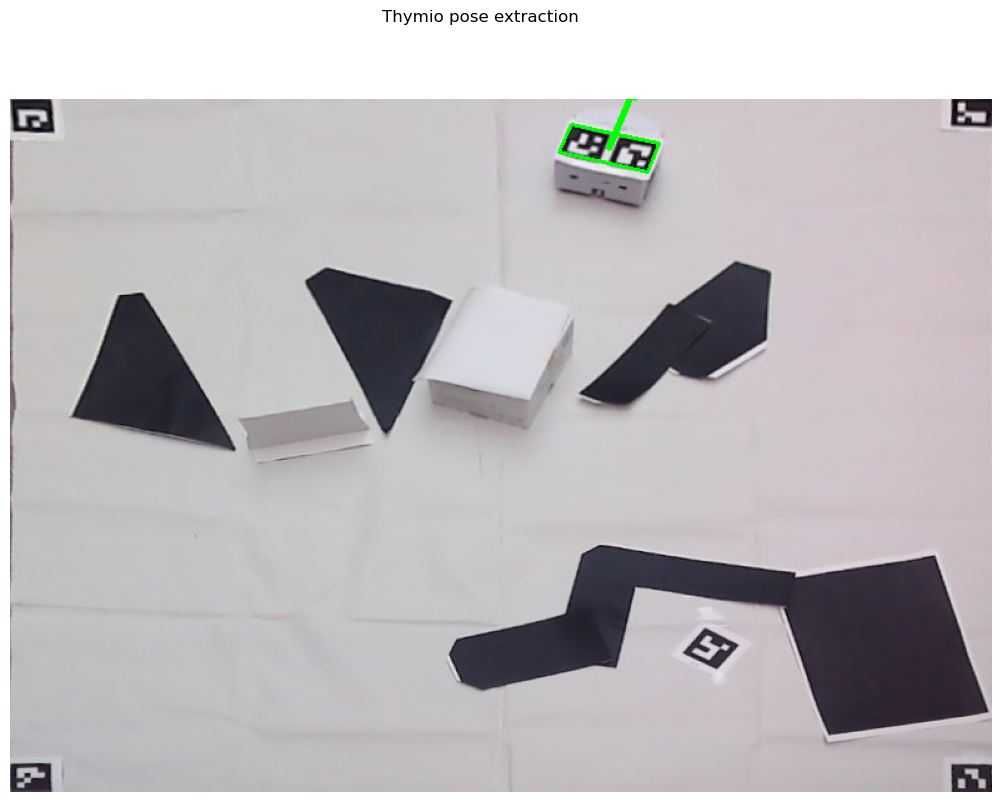

In [47]:
img_markers = env_tracker.getProjectedMap(thymio)
ret, _= env_tracker.detectMarkers(img_markers)
thymio_detected, img_markers = env_tracker.detectThymio(img_markers)
ret, thymio_pose, thymio_angle, img_markers = env_tracker.thymioPose(img_markers)
print("Estimated thymio pose: ", thymio_pose)
print("Estimated angle: %.2f" % (thymio_angle*180/np.pi))
#img_markers = detectMarkersAndPose(thymio, cam_mat, dist_coefs)
fig = plt.figure(figsize=(16,9))
fig.suptitle('Thymio pose extraction')
ax = fig.add_subplot()
ax.imshow(img_markers[:,:,::-1])
ax.axis('off')

**(EXTRA)** Detect thymio and extract pose & orientation directly in 3D world

Estimated thymio pose:  [ 67.20133625 129.166605  ]
Estimated angle: 32.79


(-0.5, 1255.5, 703.5, -0.5)

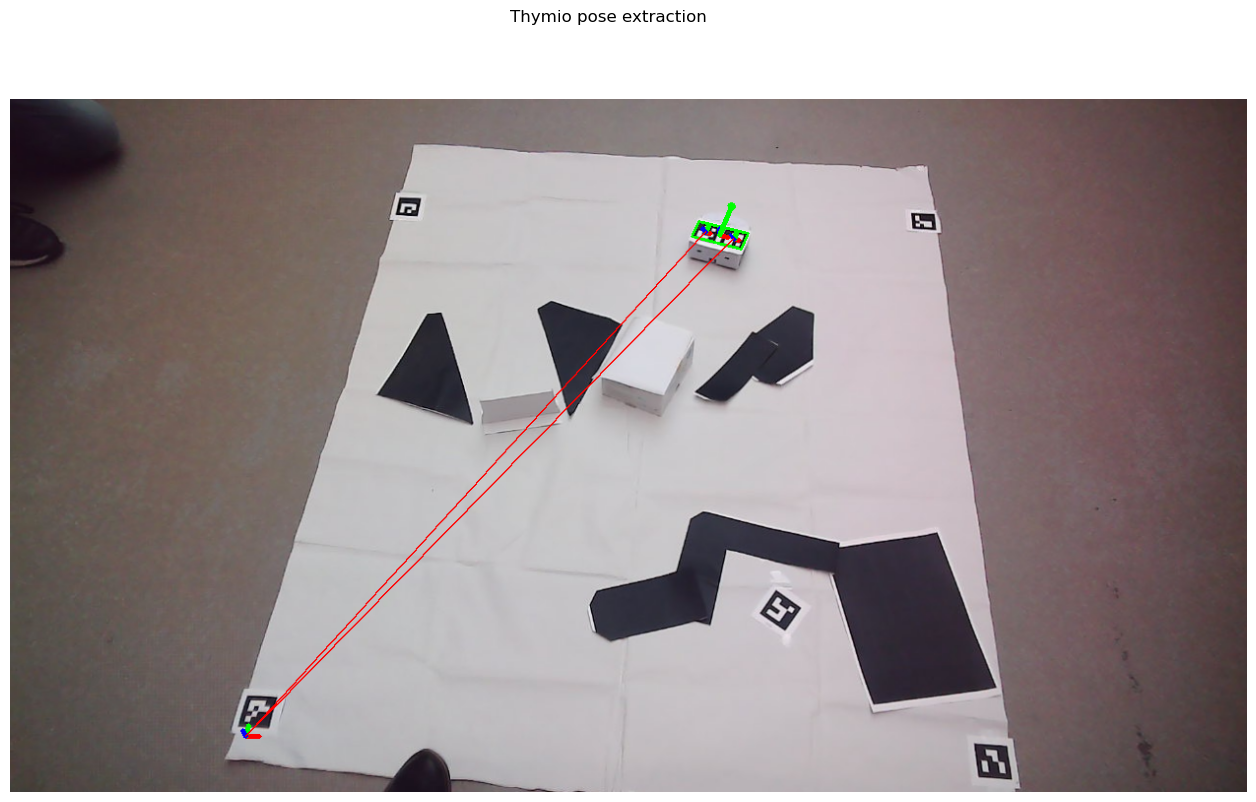

In [48]:
env_tracker.detectMarkers(thymio)
img_markers = env_tracker.extractMapCornerPose(thymio)
thymio_detected, img_markers = env_tracker.detectThymio3D(img_markers)
ret, thymio_pose, thymio_angle, img_markers = env_tracker.thymioPose3D(img_markers, show_all=True)
print("Estimated thymio pose: ", thymio_pose)
print("Estimated angle: %.2f" % (thymio_angle*180/np.pi))
#img_markers = detectMarkersAndPose(thymio, cam_mat, dist_coefs)
fig = plt.figure(figsize=(16,9))
fig.suptitle('Thymio pose extraction')
ax = fig.add_subplot()
ax.imshow(img_markers[:,:,::-1])
ax.axis('off')

### Using OpenCV GUI & realtime tracking

In [ ]:
#%matplotlib qt
# Detect map in cam feed
importlib.reload(tracker)
map_created= False
run = True
cam_calib = cb.CamCalib(None, (16,9))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()
env_tracker = tracker.EnvTracker((120,120), cam_mat, dist_coefs)
cv2.namedWindow("Live camera feed", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Live camera feed", 1680, 1050)

cam_feed = cv2.VideoCapture(0)
cam_feed.set(cv2.CAP_PROP_FRAME_WIDTH, 1680)
cam_feed.set(cv2.CAP_PROP_FRAME_HEIGHT, 1050)

# Wait for the map and the goal to be detect
map_created, grid_map, goal_pose, thymio_init_pose = env_tracker.wait_for_map(cam_feed, cam_calib)
if not map_created:
    print("WARNING :: Map was not created")
    run = False

track_thymio = False
show_markers = False
frame_counter = 0
text_pose = 'POS: ??'
text_angle = 'ANGLE: ??'
text_vel = 'VEL: ??'
text_ang_vel = 'ANG. VEL: ??'
text_goal = f'GOAL: {np.round(goal_pose, 1)}'
pose_hist = np.zeros((2,10))
angle_hist = np.zeros(10)
run = True
cv2.resizeWindow("Live camera feed", 1200, 1000)
while (run):
    success, frame = cam_feed.read()
    if not success:
        run = False
    # Detect map & thymio
    frame_corrected, roi = cam_calib.undistord(frame, cam_mat, dist_coefs)
    x,y,w,h = roi
    frame_corrected = frame_corrected[y:y+h, x:x+w, :]
    if track_thymio:
        success, thymio_pose, thymio_vel, img_thymio = env_tracker.updateThymio(frame_corrected, show_markers)
        img_sidebar = np.zeros((img_thymio.shape[0], 200, 3), dtype=np.uint8)
        if success:
            text_pose = f'POSE: {np.round(thymio_pose[:2], 1)}'
            text_angle = f'ANGLE: {round(thymio_pose[2]*180/math.pi, 0)}'
            text_vel = f'VEL: {np.round(thymio_vel[:2], 1)}'
            text_ang_vel = f'ANG. VEL: {round(thymio_vel[2]*180/math.pi, 1)}'
        cv2.putText(img_sidebar, text_pose, (10, 100), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_angle, (10, 175), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_vel, (10, 250), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_ang_vel, (10, 325), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_goal, (10, 400), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        # Concatenate images
        img_thymio = cv2.hconcat([img_thymio, img_sidebar])
    else:
        img_thymio = env_tracker.getProjectedMap(frame_corrected)
    cv2.imshow("Live camera feed",img_thymio)
    key = cv2.waitKey(1)
    if key == ord('q'):
        run = False
    elif key == ord(' '):
        track_thymio = not track_thymio
    elif key == ord('m'):
        show_markers = True
    frame_counter += 1


if cam_feed:
    cam_feed.release()
cv2.destroyAllWindows()
            

In [55]:
cam_feed.release()
cv2.destroyAllWindows()